samtools view  /run/user/1002/kio-fuse-VhcXGL/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T34896BC.bam chr8:127541853-127541928
samtools view  /run/user/1002/kio-fuse-VhcXGL/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T34896BC.bam chr14:106281499-106281574


(False, 10)

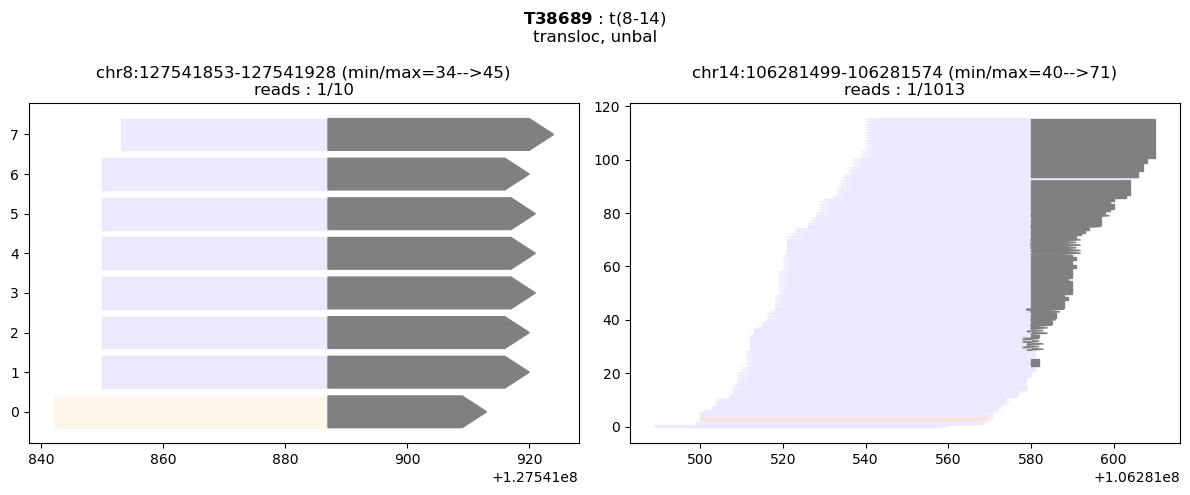

In [30]:
from pathlib import Path
import matplotlib.pyplot as plt
import vizuread as pat
import logging

logging.basicConfig(format='[%(levelname)s] [%(asctime)s] [%(module)s] %(message)s', datefmt='%H:%M:%S')


def get_reads_stats(reads, receiver) :
    evidence_reads = 0  # reads mapping for a given transloc
    noise_reads = 0     # reads mapping for other transloc
    proper_reads = 0    # properly paired reads, not bearing any translocation

    for read in reads :
        if read.is_properly_paired : 
            proper_reads += 1
        elif read.receiver_chr == receiver :
            evidence_reads += 1
        else :
            noise_reads += 1

    return evidence_reads, noise_reads, proper_reads

def check_4_14_risk(c1, end1, end2) :
    """
    Check si une translocation 4-14 est à haut risque ou pas 

    cf `Location of the t(4;14) translocation breakpoint within the NSD2 gene identifies a subset of high-risk NDMM patients`

    Définition des régions : https://genome-euro.ucsc.edu/cgi-bin/hgGene?hgg_gene=ENST00000508803.6&hgg_chrom=chr4&hgg_start=1871392&hgg_end=1982192&hgg_type=knownGene&db=hg38

    ```verb
    Transcript (Including UTRs)
    Position: hg38 chr4:1,871,393-1,982,192 Size: 110,800 Total Exon Count: 22 Strand: +
    Coding Region
    Position: hg38 chr4:1,900,655-1,978,909 Size: 78,255 Coding Exon Count: 21  
    """
    # On ne regarde que la position de fin du breakpoint 
    end = end1 if c1 == "chr4" else end2
    if int(end) < 1871393 :
        return "Low risk"
    elif int(end) < 1900655 :
        return "Medium risk"
    else : 
        return "High risk"
    
def tag_noisy_reads(reads1:list[pat.Read], reads2:list[pat.Read], color="#ebeafc") :
    """
    Tag les reads qui ne nous intéressent pas dans le cadre de la translocation
    """
    pos_1 = [r.pos for r in reads1]
    pos_2 = [r.pos for r in reads2]

    proper_reads1 = [r for r in reads1 if r.pos_receiver in pos_2 and not r.is_properly_paired]
    proper_reads2 = [r for r in reads2 if r.pos_receiver in pos_1 and not r.is_properly_paired]

    for r in reads1 + reads2 : 
        if r not in proper_reads1 + proper_reads2 : 
            setattr(r, "color", color)
            setattr(r, "noisy", True)
        else : 
            setattr(r, "noisy", False)

    return reads1, reads2


def plot_transloc(bam:Path, region:str, patient:str, transloc_id:str, transloc_type:str, balance_type:str, min_reads_covering, min_reads_total) :

    c1, c2 = region.split()
    # this way, chr14 is always c2
    if "chr14" in c1 :
        c1, c2 = c2, c1

    reads1 = list(pat.get_reads_from(
        bam, c1,
        samtools_command="samtools",
    ))

    reads2 = list(pat.get_reads_from(
        bam, c2,
        samtools_command="samtools",
    ))


    total_reads = len(reads1)

    reads1, reads2 = tag_noisy_reads(reads1, reads2)
    displayed_reads1 = [r for r in reads1 if not r.is_properly_paired]
    displayed_reads2 = [r for r in reads2 if not r.is_properly_paired]


    get_m_size = lambda x, func: str(func(r.ref_span for r in x)) if x else "None"
    minmax_read1 = "-->".join([get_m_size(displayed_reads1, min), get_m_size(displayed_reads1, max)])
    minmax_read2 = "-->".join([get_m_size(displayed_reads2, min), get_m_size(displayed_reads2, max)])

    clean_reads1 = list(filter(lambda x : not x.noisy, reads1))
    clean_reads2 = list(filter(lambda x : not x.noisy, reads2))
    evidence_reads = len(clean_reads1)

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    pat.plot_region(reads=displayed_reads1, ax=ax[0])
    ax[0].set_title(f"{c1} (min/max={minmax_read1})\nreads : {len(clean_reads1)}/{len(reads1)}")

    pat.plot_region(reads=displayed_reads2, ax=ax[1], piling="compact")
    ax[1].set_title(f"{c2} (min/max={minmax_read2})\nreads : {len(clean_reads2)}/{len(reads2)}")

    if c1 == "chr4" or c2 == "chr4" :
        risk = "(" + check_4_14_risk(c1, int(c1.split("-")[-1]), int(c2.split("-")[-1])) + ")"
    else :
        risk = ""

    plt.suptitle(
        r"$\bf{" + patient+ "}$" + f" : {transloc_id} {risk}\n"
        f"{transloc_type.lower()}, {balance_type.lower()}"
    )
    plt.tight_layout()

    return (
        fig,    # return the figure to give plotting responsibility elsewhere 
        (total_reads >= min_reads_total and evidence_reads >= min_reads_covering
        ),      # return if the given transloc is passing filters (but we plot in all cases, just in a different place)
        total_reads
    )

fig, passing, total_reads  = plot_transloc(
    "/run/user/1002/kio-fuse-VhcXGL/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T34896BC.bam",
    "chr14:106281499-106281574 chr8:127541853-127541928",
    "T38689", "t(8-14)", "transloc", "unbal", 5, 10
)
passing, total_reads